In [1]:
import os
import glob
import cv2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from sklearn.metrics import accuracy_score
from skimage.io import imread

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

image_path = "G:\Python Projects\YapayZeka\DATA\Lung Segmentation\\CXR_png\\"
mask_path = "G:\Python Projects\YapayZeka\DATA\Lung Segmentation\\masks\\"

images = os.listdir(image_path)
mask = os.listdir(mask_path)

print(len(images), len(mask))

800 704


In [3]:
mask2 = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask2]
print(len(image_file_name), len(mask))

704 704


In [4]:
check = [i for i in mask if "mask" in i]
print(len(check))

566


In [6]:
x = np.zeros((len(mask), IMG_HEIGHT, IMG_WIDTH))
y = np.zeros((len(mask), IMG_HEIGHT, IMG_WIDTH))

for i, img_id in enumerate(image_file_name):
    
    file_path = image_path  + img_id + ".png"
    
    # read the file as an array
    cv2_image = cv2.imread(file_path, 0)
    # resize the image
    cv2_image = cv2.resize(cv2_image, (IMG_HEIGHT, IMG_WIDTH))
    # save the image at the destination as a jpg file
    cv2.imwrite('img.jpg', cv2_image)
    
    # read the image using skimage
    img = imread('img.jpg')
    x[i] = img
    
    os.remove('img.jpg')

    
for i, img_id in enumerate(mask):
    
    file_path = mask_path  + img_id 
    
    # read the file as an array
    cv2_image = cv2.imread(file_path, 0)
    # resize the image
    cv2_image = cv2.resize(cv2_image, (IMG_HEIGHT, IMG_WIDTH))
    # save the image at the destination as a jpg file
    cv2.imwrite('img.jpg', cv2_image)
    
    # read the image using skimage
    img = imread('img.jpg')
    y[i] = img
    
    os.remove('img.jpg')

In [7]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    x = x[indices]
    y = y[indices]
    p = p[indices]
    dsize2 =(400,400)
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        xi = cv2.resize(x[i], dsize2)
        plt.imshow(xi)
        plt.xticks([])
        plt.yticks([])
#        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
#        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()    
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        xi = cv2.resize(y[i], dsize2)
        plt.imshow(xi)
        plt.xticks([])
        plt.yticks([])
#        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
#        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()    
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        xi = cv2.resize(p[i], dsize2)
        plt.imshow(xi)
        plt.xticks([])
        plt.yticks([])
#        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
#        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show() 

(1126, 128, 128) (1126, 128, 128)


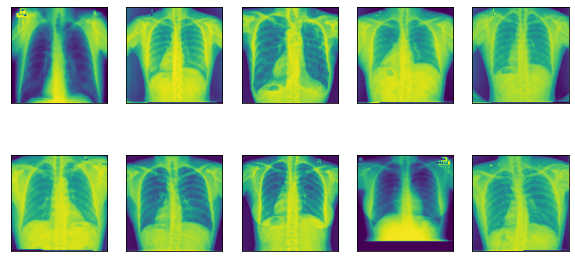

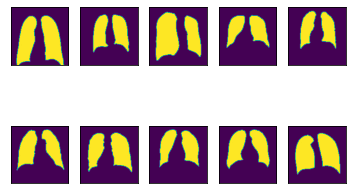

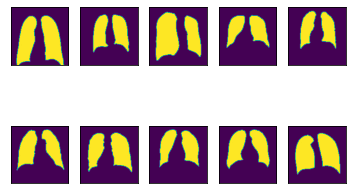

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_m, y_test_m = train_test_split(x, y, test_size=0.2, random_state=123)
x2 = np.flip(X_train , axis = 2)
y2 = np.flip(y_train_m , axis = 2)
X_train= np.append(X_train, x2,axis=0)
y_train_m = np.append(y_train_m, y2,axis=0)
print(X_train.shape,y_train_m.shape)
show_random_examples(X_train, y_train_m, y_train_m)

In [11]:
from keras_unet.models import custom_unet

model = custom_unet(
    (128, 128, 1),
    use_batch_norm=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid',
)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, verbose=1, min_delta=1e-4),
    ModelCheckpoint('model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
]

model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 128, 64) 576         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 128, 128, 64) 256         conv2d_13[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_5 (SpatialDro (None, 128, 128, 64) 0           batch_normalization_12[0][0]     
______________________________________________________________________________________________

In [13]:
y_test_m2 = (y_test_m/255.> .5).astype(int)
y_train_m2 = (y_train_m/255.> .5).astype(int)

In [14]:
model_checkpoint = ModelCheckpoint('model2.h5', monitor='loss',verbose=2, save_best_only=True)

h = model.fit(
    X_train/255., y_train_m2,   
    callbacks=callbacks,
    validation_data=(X_test/255., y_test_m2),
    epochs=15, batch_size=20,
    #validation_split=0.2,
    #shuffle=True,
)

Epoch 1/15
57/57 [==============================] - 22s 267ms/step - loss: 0.2901 - accuracy: 0.8828 - val_loss: 9.4955 - val_accuracy: 0.3403

Epoch 00001: loss improved from inf to 0.16365, saving model to model2.h5
Epoch 2/15
57/57 [==============================] - 12s 206ms/step - loss: 0.0770 - accuracy: 0.9751 - val_loss: 0.3719 - val_accuracy: 0.9352

Epoch 00002: loss improved from 0.16365 to 0.07254, saving model to model2.h5
Epoch 3/15
57/57 [==============================] - 12s 207ms/step - loss: 0.0657 - accuracy: 0.9773 - val_loss: 0.1754 - val_accuracy: 0.9598

Epoch 00003: loss improved from 0.07254 to 0.06482, saving model to model2.h5
Epoch 4/15
57/57 [==============================] - 12s 208ms/step - loss: 0.0597 - accuracy: 0.9786 - val_loss: 0.0998 - val_accuracy: 0.9683

Epoch 00004: loss improved from 0.06482 to 0.05968, saving model to model2.h5
Epoch 5/15
57/57 [==============================] - 12s 208ms/step - loss: 0.0576 - accuracy: 0.9792 - val_loss: 0.0

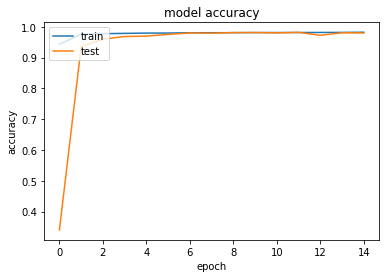

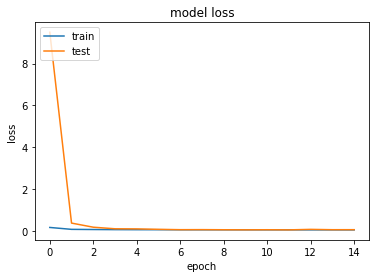

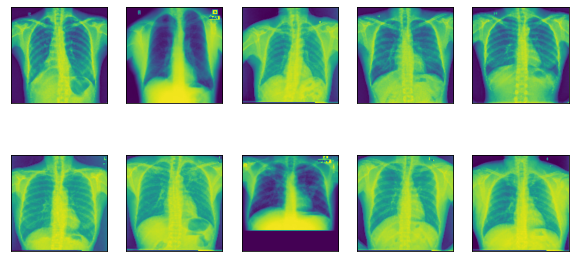

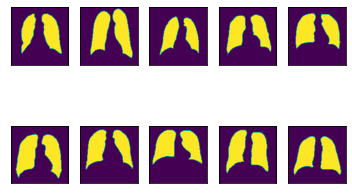

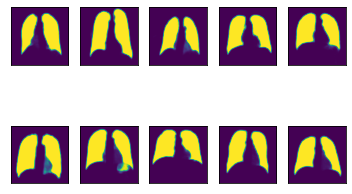

In [15]:
model = load_model("model2.h5")

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

preds = model.predict(X_test/255.)*255

show_random_examples(X_test, y_test_m, preds)

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_decay = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [17]:
h2 = model.fit(
    X_train/255., y_train_m2,
    validation_data=(X_test/255., y_test_m2),
    epochs=50, batch_size=16,
    shuffle=True,
    verbose=2,
    callbacks=[learning_rate_decay]
)

Epoch 1/50
71/71 - 15s - loss: 0.0478 - accuracy: 0.9815 - val_loss: 0.0694 - val_accuracy: 0.9776
Epoch 2/50
71/71 - 11s - loss: 0.0473 - accuracy: 0.9816 - val_loss: 0.0633 - val_accuracy: 0.9798
Epoch 3/50
71/71 - 11s - loss: 0.0463 - accuracy: 0.9818 - val_loss: 0.0526 - val_accuracy: 0.9814
Epoch 4/50
71/71 - 11s - loss: 0.0454 - accuracy: 0.9821 - val_loss: 0.0659 - val_accuracy: 0.9783
Epoch 5/50
71/71 - 11s - loss: 0.0443 - accuracy: 0.9825 - val_loss: 0.0507 - val_accuracy: 0.9825
Epoch 6/50
71/71 - 11s - loss: 0.0430 - accuracy: 0.9829 - val_loss: 0.0544 - val_accuracy: 0.9791
Epoch 7/50
71/71 - 11s - loss: 0.0417 - accuracy: 0.9833 - val_loss: 0.0531 - val_accuracy: 0.9807
Epoch 8/50
71/71 - 11s - loss: 0.0410 - accuracy: 0.9837 - val_loss: 0.0551 - val_accuracy: 0.9795
Epoch 9/50
71/71 - 10s - loss: 0.0415 - accuracy: 0.9836 - val_loss: 0.0510 - val_accuracy: 0.9817
Epoch 10/50
71/71 - 10s - loss: 0.0455 - accuracy: 0.9823 - val_loss: 2.3884 - val_accuracy: 0.7486
Epoch 11/

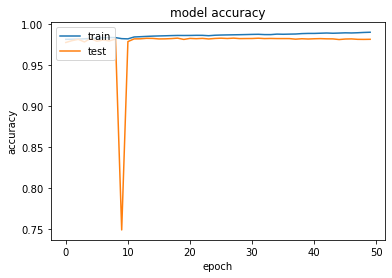

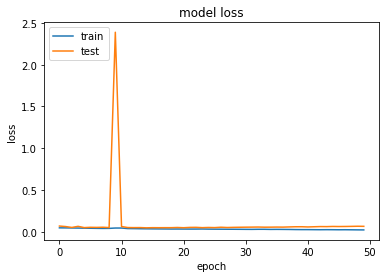

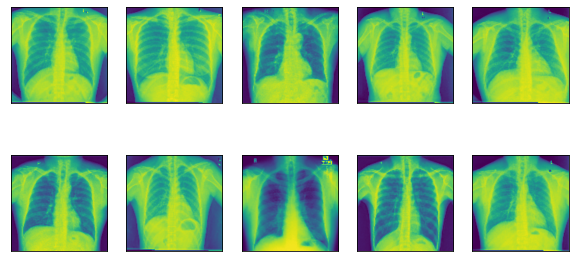

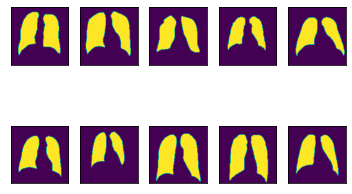

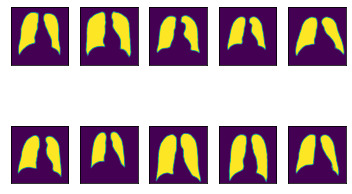

In [18]:
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h2.history['loss'])
plt.plot(h2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


losses = h2.history['loss']
accs = h2.history['accuracy']
val_losses = h2.history['val_loss']
val_accs = h2.history['val_accuracy']
epochs = len(losses)

preds2 = model.predict(X_test/255.)*255

show_random_examples(X_test, y_test_m, preds2)

In [19]:
model.save("9815_model.h5")

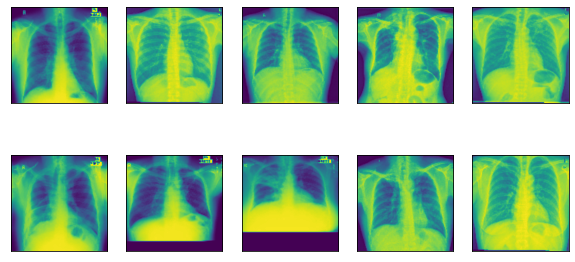

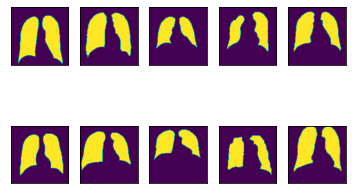

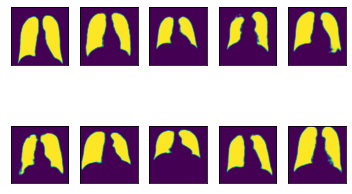

In [34]:
show_random_examples(X_test, y_test_m, preds2)